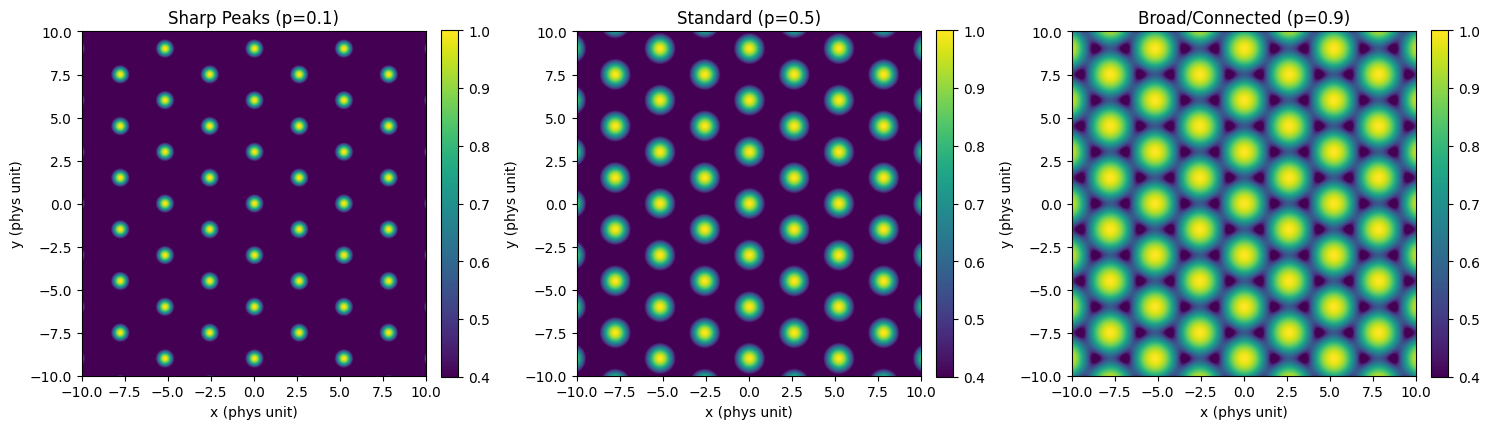

In [6]:
import numpy as np
import matplotlib.pyplot as plt

def generate_hex_lattice(
    shape: tuple = (256, 256), 
    fov: float = 10.0, 
    lattice_a: float = 1.0, 
    fill_preference: float = 0.5
) -> tuple[np.ndarray, list]:
    """
    Generates a 2D density map with hexagonal (6-fold) symmetry.
    
    The function uses the superposition of three cosine waves rotated by 120 degrees 
    to create a perfect hexagonal lattice. The output is normalized to [0, 1].

    Parameters:
    -----------
    shape : tuple (int, int)
        Resolution of the output image (height, width).
    fov : float
        Field of View in real-space units (e.g., 10.0 nm). Represents the width.
    lattice_a : float
        The lattice constant (distance between adjacent maxima).
    fill_preference : float (0.0 ~ 1.0)
        Controls the spatial occupancy of the density.
        - Closer to 0: Values near 0 dominate (Sharp, atom-like peaks).
        - Closer to 1: Values near 1 dominate (Broad plateaus, honeycomb-like).
        - 0.5: Standard cosine interference pattern.

    Returns:
    --------
    Z_final : np.ndarray
        The normalized 2D density map.
    extent : list
        [min_x, max_x, min_y, max_y] for matplotlib plotting.
    """
    ny, nx = shape
    
    # 1. Coordinate System Setup (Centered at 0)
    # Aspect ratio correction to keep pixels square
    aspect_ratio = ny / nx
    x_range = fov
    y_range = fov * aspect_ratio
    
    x = np.linspace(-x_range/2, x_range/2, nx)
    y = np.linspace(-y_range/2, y_range/2, ny)
    X, Y = np.meshgrid(x, y)
    
    # 2. Wave Vector Definition (Reciprocal Space)
    # For a triangular lattice with constant 'a', |k| = 4*pi / (sqrt(3)*a)
    k_mag = (4 * np.pi) / (np.sqrt(3) * lattice_a)
    
    # Three wave vectors rotated by 120 degrees (2*pi/3)
    # k1: 0 deg, k2: 120 deg, k3: 240 deg
    angles = np.array([0, 2*np.pi/3, 4*np.pi/3])
    
    # 3. Superposition of Plane Waves
    Z_raw = np.zeros_like(X)
    for theta in angles:
        # kx, ky components
        kx = k_mag * np.cos(theta)
        ky = k_mag * np.sin(theta)
        
        # Add cosine wave: cos(k dot r)
        Z_raw += np.cos(kx * X + ky * Y)
        
    # 4. Normalization (0 to 1)
    # Analytical min/max for 3-cosine sum are -1.5 and 3.0, but we use data min/max for safety
    z_min, z_max = Z_raw.min(), Z_raw.max()
    Z_norm = (Z_raw - z_min) / (z_max - z_min)
    
    # 5. Shaping (Fill Preference) via Gamma Correction
    # Mapping: p=0 -> gamma=high(sharp), p=1 -> gamma=low(broad)
    # Using an exponential scale factor for smooth transition
    # fill_preference 0.0 -> exponent ~ 4.0 (Sharp)
    # fill_preference 0.5 -> exponent = 1.0 (Neutral)
    # fill_preference 1.0 -> exponent ~ 0.25 (Fat)
    gamma = 4.0 ** (1 - 2 * fill_preference)
    
    Z_final = Z_norm ** gamma
    
    # Ensure strict 0-1 range (floating point errors might cause slight drift)
    Z_final = np.clip(Z_final, 0.0, 1.0)
    
    # Extent for plotting [left, right, bottom, top]
    extent = [x.min(), x.max(), y.min(), y.max()]
    
    return Z_final, extent

# --- Example Usage Code ---
if __name__ == "__main__":
    # Parameters
    a_lattice = 3.0  # e.g., 3.0 nm CDW wavelength
    fov_size = 20.0  # 20 nm scan size
    
    # Generate 3 variations
    prefs = [0.1, 0.5, 0.99]
    titles = ["Sharp Peaks (p=0.1)", "Standard (p=0.5)", "Broad/Connected (p=0.9)"]
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    for ax, p, title in zip(axes, prefs, titles):
        density, extent = generate_hex_lattice(
            shape=(512, 512), 
            fov=fov_size, 
            lattice_a=a_lattice, 
            fill_preference=p
        )
        
        im = ax.imshow(density, extent=extent, origin='lower', cmap='viridis', clim=(.4, 1))
        ax.set_title(title)
        ax.set_xlabel("x (phys unit)")
        ax.set_ylabel("y (phys unit)")
        fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

    plt.tight_layout()
    plt.show()

In [8]:
import numpy as np
from scipy.ndimage import distance_transform_edt


def hex_density_field(
    shape,
    lattice_constant,
    preference=0.5,
    handle=0.0,
    extent=None,
    origin=(0.0, 0.0),
    return_meta=False,
):
    """
    Hexagonal symmetric density field with controllable topology.

    Parameters
    ----------
    shape : (Ny, Nx)
    lattice_constant : float
        Real-space lattice constant a
    preference : float in [0,1]
        Histogram bias (0 -> low values dominate, 1 -> high values dominate)
    handle : float in [0,1]
        0 : point minima (cosine-wave Morse field)
        1 : line minima (Voronoi skeleton / Wigner–Seitz edges)
    extent : (Ly, Lx), optional
        Physical size of the domain
    origin : (y0, x0)
        Phase shift
    return_meta : bool

    Returns
    -------
    rho : ndarray (Ny, Nx), values in [0,1]
    """

    Ny, Nx = shape
    a = lattice_constant

    if extent is None:
        Ly, Lx = Ny * a, Nx * a
    else:
        Ly, Lx = extent

    y = np.linspace(-Ly / 2, Ly / 2, Ny) + origin[0]
    x = np.linspace(-Lx / 2, Lx / 2, Nx) + origin[1]
    Y, X = np.meshgrid(y, x, indexing="ij")

    # --- Reciprocal lattice vectors ---
    k = 4 * np.pi / (np.sqrt(3) * a)
    kvecs = np.array([
        [k, 0.0],
        [0.5 * k, np.sqrt(3) / 2 * k],
        [-0.5 * k, np.sqrt(3) / 2 * k],
    ])

    # --- Wave-based hex field ---
    rho_wave = np.zeros_like(X)
    for kx, ky in kvecs:
        rho_wave += np.cos(kx * X + ky * Y)

    # Normalize to [0,1]
    rho_wave = (rho_wave - rho_wave.min()) / (rho_wave.max() - rho_wave.min())

    # --- Pseudo-distance from wave minima ---
    d_wave = np.sqrt(1.0 - rho_wave)

    # --- Skeleton distance (Voronoi / Wigner–Seitz edges) ---
    # Skeleton defined as points equidistant from ≥2 nearest maxima
    # Approximate via thresholded wave field
    ridge = rho_wave < np.quantile(rho_wave, 0.15)
    d_skel = distance_transform_edt(~ridge)
    d_skel = d_skel / d_skel.max()

    # --- Interpolated distance ---
    h = np.clip(handle, 0.0, 1.0)
    d = (1 - h) * d_wave + h * d_skel
    d = d / d.max()

    # --- Distance → density ---
    rho = d**2
    rho = (rho - rho.min()) / (rho.max() - rho.min())

    # --- Preference warping ---
    if preference != 0.5:
        gamma = np.exp(4 * (0.5 - preference))
        rho = rho**gamma
        rho = (rho - rho.min()) / (rho.max() - rho.min())

    if return_meta:
        meta = {
            "lattice_constant": a,
            "preference": preference,
            "handle": handle,
            "extent": (Ly, Lx),
            "symmetry": "C6",
        }
        return rho, meta

    return rho


MemoryError: Unable to allocate 773. GiB for an array with shape (648025, 400, 400) and data type float64

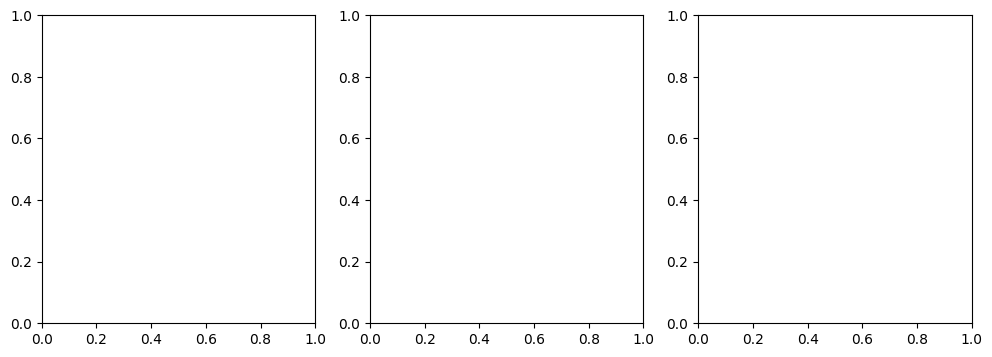

In [11]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(12, 4))

handles = [0.0, 0.5, 1.0]
titles = ["handle = 0 (point minima)",
          "handle = 0.5 (hybrid)",
          "handle = 1 (line minima)"]

for ax, h, title in zip(axes, handles, titles):
    rho = hex_density_field(
        shape=(400, 400),
        lattice_constant=200.0,
        preference=0.5,
        handle=h,
    )
    ax.imshow(rho, cmap="inferno", origin="lower")
    ax.set_title(title)
    ax.axis("off")

plt.tight_layout()
plt.show()


In [12]:
import numpy as np
from scipy.ndimage import distance_transform_edt


def hex_density_field(
    shape,
    lattice_constant,
    preference=0.5,
    handle=0.0,
    extent=None,
    origin=(0.0, 0.0),
    return_meta=False,
):
    Ny, Nx = shape
    a = lattice_constant

    if extent is None:
        Ly, Lx = Ny * a, Nx * a
    else:
        Ly, Lx = extent

    y = np.linspace(-Ly / 2, Ly / 2, Ny) + origin[0]
    x = np.linspace(-Lx / 2, Lx / 2, Nx) + origin[1]
    Y, X = np.meshgrid(y, x, indexing="ij")

    # -----------------------------
    # 1. Generate hex lattice points
    # -----------------------------
    nmax = int(max(Lx, Ly) / a) + 2
    lattice_pts = []

    for i in range(-nmax, nmax + 1):
        for j in range(-nmax, nmax + 1):
            px = a * (i + 0.5 * j)
            py = a * (np.sqrt(3) / 2 * j)
            lattice_pts.append((py, px))

    lattice_pts = np.array(lattice_pts)

    # ---------------------------------
    # 2. Distance to nearest lattice pt
    # ---------------------------------
    dists = np.zeros((len(lattice_pts), Ny, Nx))
    for idx, (py, px) in enumerate(lattice_pts):
        dists[idx] = np.sqrt((Y - py) ** 2 + (X - px) ** 2)

    d_sorted = np.sort(dists, axis=0)
    d1, d2 = d_sorted[0], d_sorted[1]

    # ---------------------------------
    # 3. Skeleton = Voronoi edges
    # ---------------------------------
    eps = 0.03 * a
    skeleton = np.abs(d1 - d2) < eps

    d_skel = distance_transform_edt(~skeleton)
    d_skel /= d_skel.max()

    # ---------------------------------
    # 4. Wave-based pseudo-distance
    # ---------------------------------
    k = 4 * np.pi / (np.sqrt(3) * a)
    kvecs = np.array([
        [k, 0.0],
        [0.5 * k, np.sqrt(3) / 2 * k],
        [-0.5 * k, np.sqrt(3) / 2 * k],
    ])

    rho_wave = np.zeros_like(X)
    for kx, ky in kvecs:
        rho_wave += np.cos(kx * X + ky * Y)

    rho_wave = (rho_wave - rho_wave.min()) / (rho_wave.max() - rho_wave.min())
    d_wave = np.sqrt(1.0 - rho_wave)

    # ---------------------------------
    # 5. Interpolate distances
    # ---------------------------------
    h = np.clip(handle, 0.0, 1.0)
    d = (1 - h) * d_wave + h * d_skel
    d /= d.max()

    # ---------------------------------
    # 6. Distance → density
    # ---------------------------------
    rho = d ** 2
    rho = (rho - rho.min()) / (rho.max() - rho.min())

    # ---------------------------------
    # 7. Preference warping
    # ---------------------------------
    if preference != 0.5:
        gamma = np.exp(4 * (0.5 - preference))
        rho = rho ** gamma
        rho = (rho - rho.min()) / (rho.max() - rho.min())

    if return_meta:
        meta = {
            "lattice_constant": a,
            "preference": preference,
            "handle": handle,
            "symmetry": "C6",
        }
        return rho, meta

    return rho


In [15]:
import numpy as np
from scipy.ndimage import distance_transform_edt


def hex_density_field(
    shape,
    lattice_constant,
    preference=0.5,
    handle=0.0,
    extent=None,
    origin=(0.0, 0.0),
    return_meta=False,
):
    """
    Hexagonal-symmetric density field with controllable topology.

    Parameters
    ----------
    shape : (Ny, Nx)
        Output resolution
    lattice_constant : float
        Triangular lattice constant
    preference : float in [0,1]
        Histogram bias (0: low values dominate, 1: high values dominate)
    handle : float in [0,1]
        0: point minima (triangular void)
        1: line minima (hexagonal skeleton)
    extent : (Ly, Lx), optional
        Physical size of domain
    origin : (y0, x0)
        Phase shift
    return_meta : bool

    Returns
    -------
    rho : ndarray (Ny, Nx), values in [0,1]
    """

    # -------------------------
    # 0. Grid
    # -------------------------
    Ny, Nx = shape
    a = lattice_constant

    if extent is None:
        Ly, Lx = Ny * a, Nx * a
    else:
        Ly, Lx = extent

    y = np.linspace(-Ly / 2, Ly / 2, Ny) + origin[0]
    x = np.linspace(-Lx / 2, Lx / 2, Nx) + origin[1]
    Y, X = np.meshgrid(y, x, indexing="ij")

    # -------------------------
    # 1. Point-minimum field
    #    (hexagonal cosine sum)
    # -------------------------
    k = 4 * np.pi / (np.sqrt(3) * a)
    kvecs = np.array([
        [k, 0.0],
        [0.5 * k,  np.sqrt(3) / 2 * k],
        [-0.5 * k, np.sqrt(3) / 2 * k],
    ])

    wave = np.zeros_like(X)
    for kx, ky in kvecs:
        wave += np.cos(kx * X + ky * Y)

    wave = (wave - wave.min()) / (wave.max() - wave.min())
    d_point = np.sqrt(1.0 - wave)   # 0 at triangular void points

    # -------------------------
    # 2. Hexagonal skeleton
    #    (Voronoi edge network)
    # -------------------------
    # Generate lattice points
    nmax = int(max(Lx, Ly) / a) + 2
    lattice_pts = []

    for i in range(-nmax, nmax + 1):
        for j in range(-nmax, nmax + 1):
            px = a * (i + 0.5 * j)
            py = a * (np.sqrt(3) / 2 * j)
            lattice_pts.append((py, px))

    lattice_pts = np.array(lattice_pts)

    # Distance to nearest & 2nd nearest lattice point
    dists = np.empty((len(lattice_pts), Ny, Nx))
    for idx, (py, px) in enumerate(lattice_pts):
        dists[idx] = np.sqrt((Y - py) ** 2 + (X - px) ** 2)

    d_sorted = np.sort(dists, axis=0)
    d1, d2 = d_sorted[0], d_sorted[1]

    # Skeleton = equidistant locus
    eps = 0.03 * a
    skeleton = np.abs(d1 - d2) < eps

    d_skel = distance_transform_edt(~skeleton)
    d_skel /= d_skel.max()

    # -------------------------
    # 3. Distance interpolation
    # -------------------------
    h = np.clip(handle, 0.0, 1.0)
    d = (1 - h) * d_point + h * d_skel
    d /= d.max()

    # -------------------------
    # 4. Distance → density
    # -------------------------
    rho = d ** 2
    rho = (rho - rho.min()) / (rho.max() - rho.min())

    # -------------------------
    # 5. Preference warping
    # -------------------------
    if preference != 0.5:
        gamma = np.exp(4 * (0.5 - preference))
        rho = rho ** gamma
        rho = (rho - rho.min()) / (rho.max() - rho.min())

    if return_meta:
        meta = {
            "lattice_constant": a,
            "preference": preference,
            "handle": handle,
            "symmetry": "C6",
        }
        return rho, meta

    return rho


MemoryError: Unable to allocate 773. GiB for an array with shape (648025, 400, 400) and data type float64

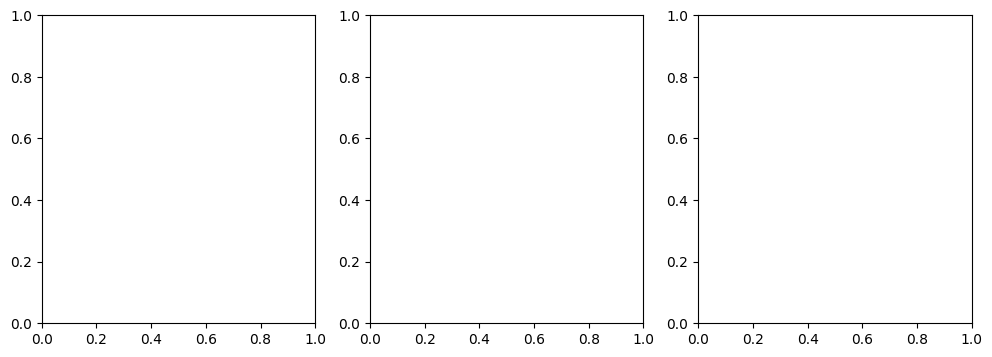

In [16]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(12, 4))
handles = [0.0, 0.5, 1.0]

for ax, h in zip(axes, handles):
    rho = hex_density_field(
        shape=(400, 400),
        lattice_constant=20.0,
        preference=0.5,
        handle=h,
    )
    ax.imshow(rho, origin="lower", cmap="inferno")
    ax.set_title(f"handle = {h}")
    ax.axis("off")

plt.tight_layout()
plt.show()


0.0
0.0
0.0


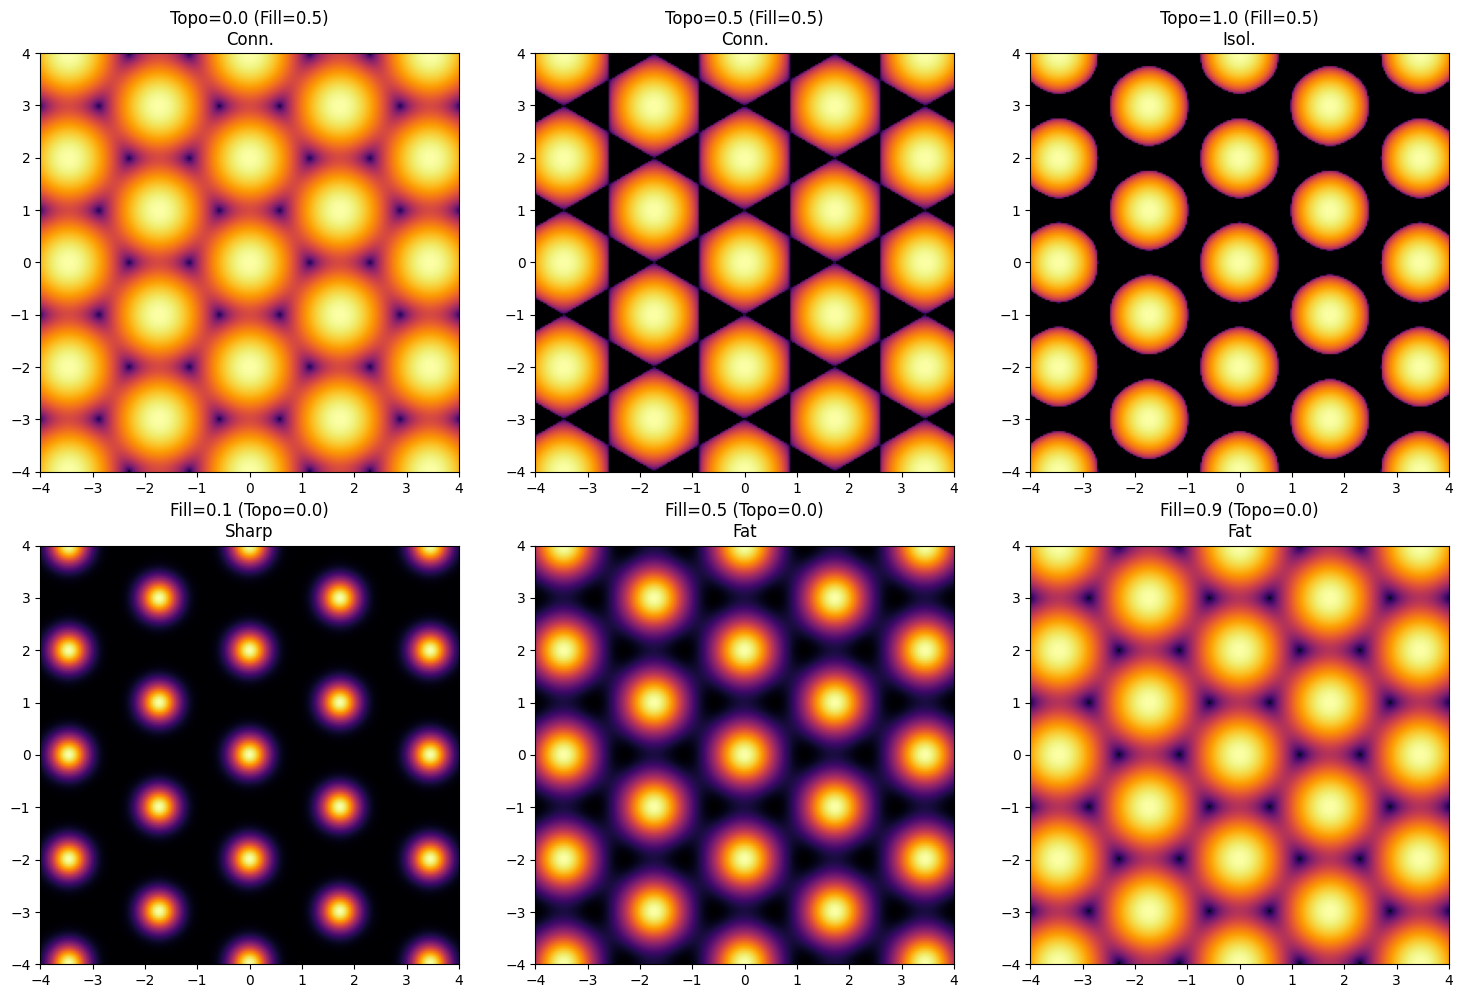

In [29]:
import numpy as np
import matplotlib.pyplot as plt

def generate_hex_lattice_v2(
    shape: tuple = (256, 256), 
    fov: float = 10.0, 
    lattice_a: float = 1.0, 
    fill_preference: float = 0.5,
    topology_param: float = 0.0
) -> tuple[np.ndarray, list]:
    """
    Generates a 6-fold symmetric hexagonal lattice density map with topological control.

    Parameters:
    -----------
    shape : tuple
        (height, width) in pixels.
    fov : float
        Real-space width of the image (e.g., 10.0 nm).
    lattice_a : float
        Lattice constant (distance between maxima).
    fill_preference : float (0.0 ~ 1.0)
        Controls density width (Gamma correction).
        0.0 = Sharp/Thin peaks, 1.0 = Broad/Fat plateaus.
    topology_param : float (0.0 ~ 1.0)
        Controls the zero-level floor (Topological connectivity).
        0.0 = Minimum is at triangular voids (Skeleton is connected).
        1.0 = Minimum includes the hexagonal skeleton (Maxima are isolated).

    Returns:
    --------
    Z_final : np.ndarray
        Normalized density map [0, 1].
    extent : list
        [min_x, max_x, min_y, max_y] for plotting.
    """
    ny, nx = shape
    
    # 1. Grid Generation (Centered at 0,0)
    aspect_ratio = ny / nx
    x = np.linspace(-fov/2, fov/2, nx)
    y = np.linspace(-fov*aspect_ratio/2, fov*aspect_ratio/2, ny)
    X, Y = np.meshgrid(x, y)
    
    # 2. 3-Plane Wave Interference
    # Wave vector magnitude for triangular lattice
    k_mag = (4 * np.pi) / (np.sqrt(3) * lattice_a)
    
    # Three wave vectors at 0, 120, 240 degrees
    # This guarantees the center (0,0) is a Maximum (Phase aligned)
    angles = [0, 2*np.pi/3, 4*np.pi/3]
    Z_raw = np.zeros_like(X)
    for theta in angles:
        Z_raw += np.cos(k_mag * (X * np.cos(theta) + Y * np.sin(theta)))
        
    # 3. Initial Normalization [0, 1]
    # Analytical range of sum(3 cos): [-1.5, 3.0]
    # We use dynamic min/max to be safe against floating point drift
    z_min, z_max = Z_raw.min(), Z_raw.max()
    Z_norm = (Z_raw - z_min) / (z_max - z_min)
    
    # 4. Topology Control (Parameter 3)
    # The saddle point (bridge between atoms) in a standard 3-cosine wave 
    # sits mathematically at normalized value ~ 0.222 (which is 1/4.5)
    saddle_level_norm = 0.2222 
    
    # Define the new "floor" based on topology_param
    # If param=0, floor=0. If param=1, floor=saddle_level
    current_floor = topology_param * saddle_level_norm
    
    # Shift and Clip
    Z_topo = Z_norm - current_floor
    Z_topo = np.maximum(Z_topo, 0.0) # Clip negative values to 0
    
    # Re-normalize max to 1.0 (if max > 0)
    topo_max = Z_topo.max()
    if topo_max > 0:
        Z_topo /= topo_max
        
    # 5. Fill Preference (Parameter 2) via Gamma Correction
    # p=0 (sharp) -> gamma=4, p=1 (fat) -> gamma=0.25
    gamma = 4.0 ** (1.0 - 2.0 * fill_preference)
    Z_final = Z_topo ** gamma
    
    extent = [x.min(), x.max(), y.min(), y.max()]
    
    return Z_final, extent

# --- Verification & Plotting Code ---
if __name__ == "__main__":
    # Settings for demonstration
    a_val = 2.0  # Unit cell 2.0 units
    fov_val = 8.0
    
    # Create a 2x3 grid to show parameter effects
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    
    # Row 1: Vary Topology (keeping Fill Preference neutral)
    # Shows transition from "Connected Net" to "Isolated Dots"
    topo_vals = [0.0, 0.5, 1.0]
    for ax, t in zip(axes[0], topo_vals):
        z, ext = generate_hex_lattice_v2(
            topology_param=t, fill_preference=1, 
            lattice_a=a_val, fov=fov_val
        )
        ax.imshow(z, extent=ext, origin='lower', cmap='inferno', vmin=0, vmax=1)
        print(z.min())
        ax.set_title(f"Topo={t} (Fill=0.5)\n{'Conn.' if t<0.8 else 'Isol.'}")
        ax.grid(False)

    # Row 2: Vary Fill Preference (keeping Topology neutral)
    # Shows transition from "Needles" to "Plateaus"
    fill_vals = [0.1, 0.5, 0.9]
    for ax, f in zip(axes[1], fill_vals):
        z, ext = generate_hex_lattice_v2(
            topology_param=0.0, fill_preference=f, 
            lattice_a=a_val, fov=fov_val
        )
        ax.imshow(z, extent=ext, origin='lower', cmap='inferno')
        ax.set_title(f"Fill={f} (Topo=0.0)\n{'Sharp' if f<0.5 else 'Fat'}")
        ax.grid(False)

    plt.tight_layout()
    plt.show()

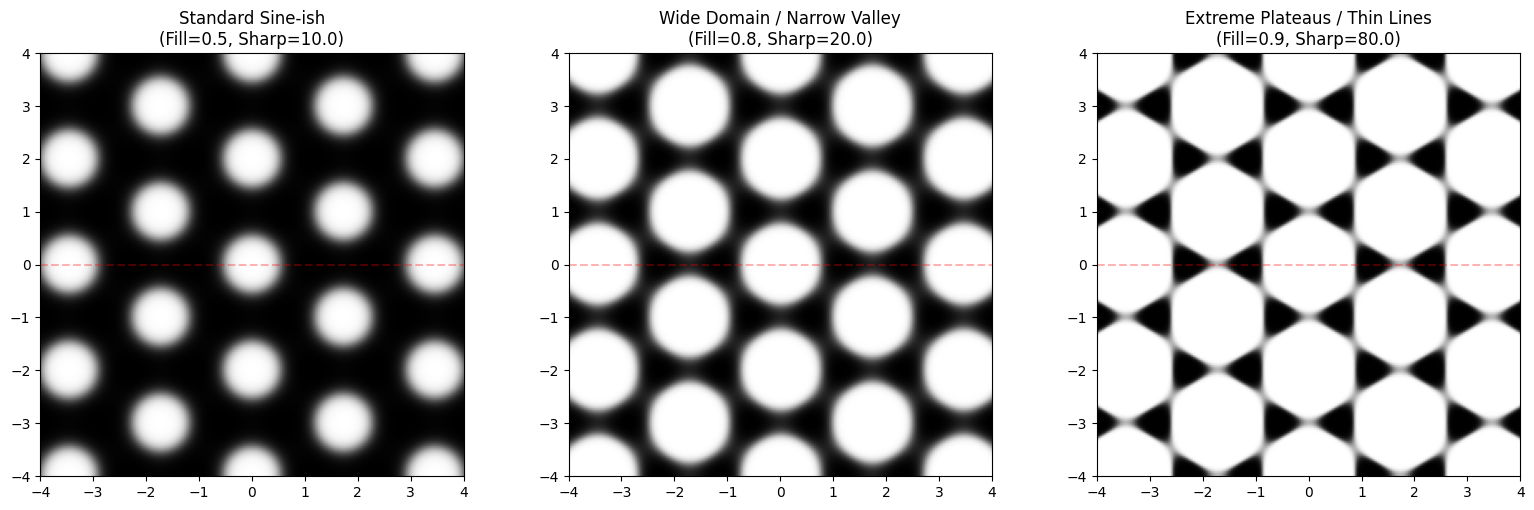

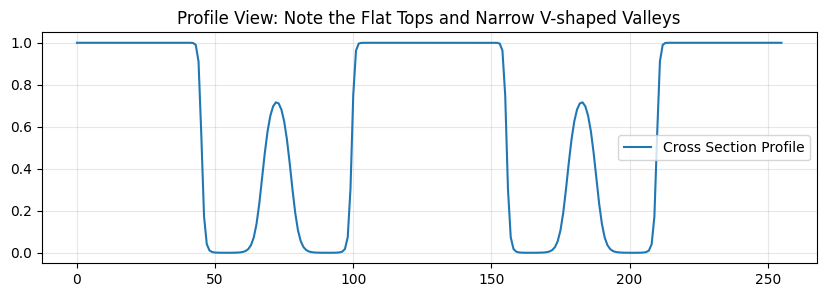

In [31]:
import numpy as np
import matplotlib.pyplot as plt

def generate_hex_lattice_v3(
    shape: tuple = (256, 256), 
    fov: float = 10.0, 
    lattice_a: float = 1.0, 
    fill_preference: float = 0.8,
    wall_sharpness: float = 20.0
) -> tuple[np.ndarray, list]:
    """
    Generates a hexagonal lattice with sharp 'domain wall' like features using Sigmoid shaping.

    Parameters:
    -----------
    shape : tuple
        (height, width) in pixels.
    fov : float
        Real-space width (e.g., 10.0 nm).
    lattice_a : float
        Lattice constant.
    fill_preference : float (0.0 ~ 1.0)
        Determines the size of the domains (atoms).
        - High value (> 0.7): Large flat domains separated by narrow lines (Your Request).
        - Low value (< 0.3): Small dots separated by wide empty space.
    wall_sharpness : float (default ~ 20.0)
        Controls the steepness of the transition.
        - Higher values make the valleys look like thin, sharp lines.
        - Lower values make the transitions smoother (sine-wave like).

    Returns:
    --------
    Z_final : np.ndarray (Normalized 0~1)
    extent : list [min_x, max_x, min_y, max_y]
    """
    ny, nx = shape
    
    # 1. Grid Generation
    aspect_ratio = ny / nx
    x = np.linspace(-fov/2, fov/2, nx)
    y = np.linspace(-fov*aspect_ratio/2, fov*aspect_ratio/2, ny)
    X, Y = np.meshgrid(x, y)
    
    # 2. 3-Plane Wave Interference (Base Lattice)
    k_mag = (4 * np.pi) / (np.sqrt(3) * lattice_a)
    angles = [0, 2*np.pi/3, 4*np.pi/3]
    
    Z_raw = np.zeros_like(X)
    for theta in angles:
        Z_raw += np.cos(k_mag * (X * np.cos(theta) + Y * np.sin(theta)))
        
    # Normalize Raw Wave to [0, 1] first
    z_min, z_max = Z_raw.min(), Z_raw.max()
    Z_norm = (Z_raw - z_min) / (z_max - z_min)
    
    # 3. Sigmoid Shaping for Domain Walls
    # We shift the center of the sigmoid based on fill_preference.
    # If fill_preference is high (0.8), we want the threshold to be low (0.2), 
    # so most values pass the threshold and become 1 (Plateau), leaving narrow 0 valleys.
    
    # Invert mapping: 0.9 preference -> 0.1 threshold
    sigmoid_threshold = 1.0 - fill_preference
    
    # Apply Sigmoid: 1 / (1 + exp(-k * (x - x0)))
    # (x - x0) shifts the wave up/down relative to the inflection point
    Z_sig = 1.0 / (1.0 + np.exp(-wall_sharpness * (Z_norm - sigmoid_threshold)))
    
    # 4. Final Renormalization
    # Sigmoid output is strictly (0, 1) but might not touch exactly 0 or 1 depending on sharpness
    Z_final = (Z_sig - Z_sig.min()) / (Z_sig.max() - Z_sig.min())
    
    extent = [x.min(), x.max(), y.min(), y.max()]
    
    return Z_final, extent

# --- Example: Visualize the "Line-like Valley" effect ---
if __name__ == "__main__":
    a_val = 2.0
    fov_val = 8.0
    
    # Settings specifically tuned for "Narrow Domain Walls"
    # High Fill Preference + High Sharpness = Narrow Lines
    params = [
        (0.5, 10.0, "Standard Sine-ish"),
        (0.8, 20.0, "Wide Domain / Narrow Valley"),
        (0.9, 80.0, "Extreme Plateaus / Thin Lines")
    ]
    
    fig, axes = plt.subplots(1, 3, figsize=(16, 5))
    
    for ax, (fill, sharp, label) in zip(axes, params):
        z, ext = generate_hex_lattice_v3(
            fill_preference=fill, 
            wall_sharpness=sharp,
            lattice_a=a_val, 
            fov=fov_val
        )
        
        # Plotting
        im = ax.imshow(z, extent=ext, origin='lower', cmap='gray')
        ax.set_title(f"{label}\n(Fill={fill}, Sharp={sharp})")
        
        # Add a cross-section line to show the "Cliff" profile
        ax.axhline(0, color='red', alpha=0.3, linestyle='--')
        
    plt.tight_layout()
    plt.show()

    # Visualize the Profile (Cross-section) of the last one
    plt.figure(figsize=(10, 3))
    plt.plot(z[z.shape[0]//2, :], label="Cross Section Profile")
    plt.title("Profile View: Note the Flat Tops and Narrow V-shaped Valleys")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

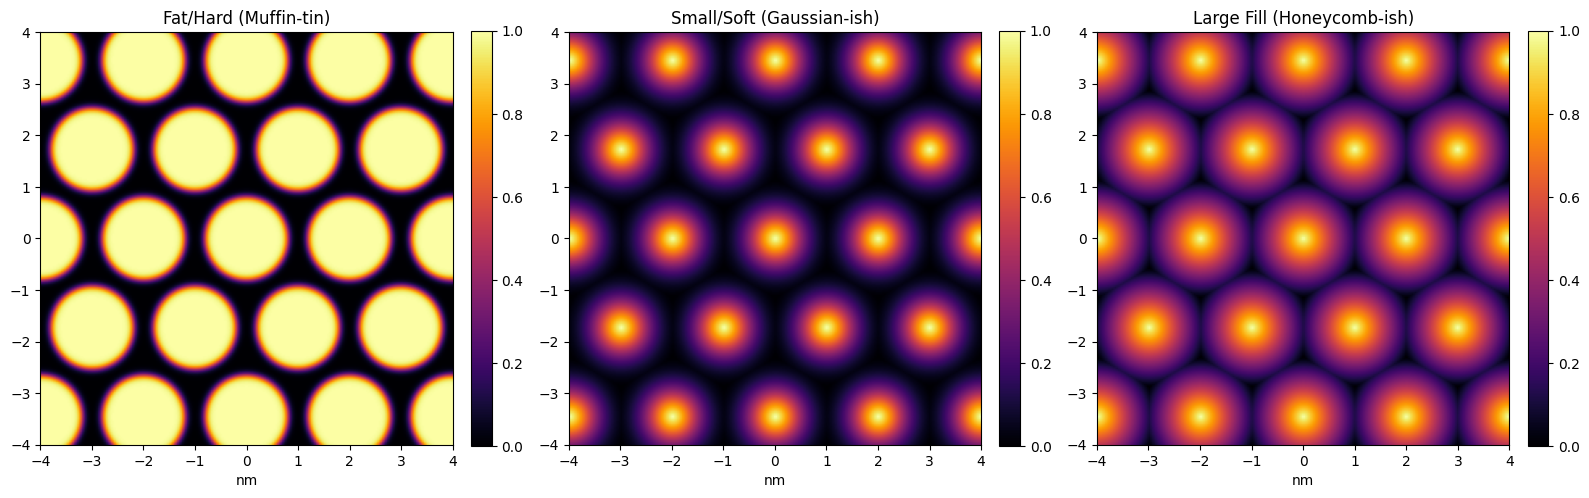

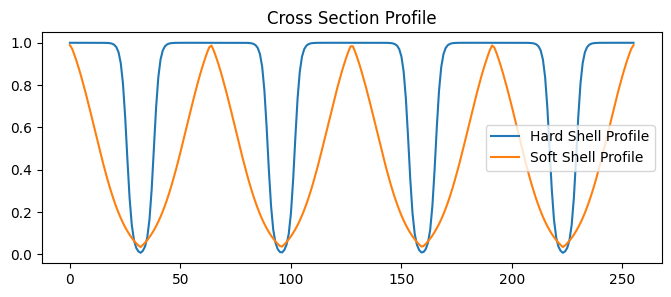

In [43]:
import numpy as np
import matplotlib.pyplot as plt

def generate_distance_field_lattice(
    shape: tuple = (256, 256), 
    fov: float = 10.0, 
    lattice_a: float = 1.0, 
    step_center: float = 0.5, 
    step_sharpness: float = 20.0
) -> tuple[np.ndarray, list]:
    """
    Generates a hexagonal lattice density map using a Distance Field algorithm.
    
    Algorithm:
    1. Calculate phi(x,y): Euclidean distance to the nearest lattice point.
       (phi is non-smooth at Voronoi boundaries).
    2. Normalize phi: 0 at lattice point, 1 at triangular void center.
    3. Apply Sigmoid Shaping: s(phi) -> Maps distance to density [0, 1].

    Parameters:
    -----------
    shape : tuple
        Output resolution (height, width).
    fov : float
        Field of View in real space (e.g., 10.0 nm).
    lattice_a : float
        Lattice constant (distance between atoms).
    step_center : float (0.0 ~ 1.0)
        The radius of the 'atom' or 'domain'.
        - Defines the threshold distance where density drops to 0.5.
        - Larger value = Fatter atoms / Smaller voids.
    step_sharpness : float
        The hardness of the domain edge.
        - High value (>50): Sharp, binary-like edges (Hard spheres).
        - Low value (<10): Soft, fuzzy edges (Gaussian-like).

    Returns:
    --------
    Z_final : np.ndarray
        Density map normalized to [0, 1].
    extent : list
        [min_x, max_x, min_y, max_y] for plotting.
    """
    ny, nx = shape
    
    # 1. Grid Generation (Real Space)
    aspect_ratio = ny / nx
    x = np.linspace(-fov/2, fov/2, nx)
    y = np.linspace(-fov*aspect_ratio/2, fov*aspect_ratio/2, ny)
    X, Y = np.meshgrid(x, y)
    
    # 2. Coordinate Transformation to Hexagonal Basis (u, v)
    # Basis vectors: a1 = (a, 0), a2 = (a/2, a*sqrt(3)/2)
    # We want to find u, v such that (x,y) = u*a1 + v*a2
    # Derived inverse:
    # u = x/a - y/(a*sqrt(3))
    # v = 2y / (a*sqrt(3))
    
    sqrt3 = np.sqrt(3)
    u_raw = X / lattice_a - Y / (lattice_a * sqrt3)
    v_raw = 2 * Y / (lattice_a * sqrt3)
    
    # 3. Find Nearest Lattice Point (Vectorized)
    # The nearest integer point (i,j) in oblique coordinates is one of the 
    # 4 corners of the parallelogram enclosing (u, v).
    
    u_floor = np.floor(u_raw)
    v_floor = np.floor(v_raw)
    
    # Candidate integer coordinates (4 neighbors)
    # We stack them to shape (4, ny, nx) to compute min distance efficiently
    candidates_u = np.stack([u_floor, u_floor+1, u_floor, u_floor+1])
    candidates_v = np.stack([v_floor, v_floor, v_floor+1, v_floor+1])
    
    # Convert candidates back to Real Space (Cartesian)
    # x = (u + v/2) * a
    # y = (sqrt(3)/2 * v) * a
    cand_x = (candidates_u + candidates_v / 2.0) * lattice_a
    cand_y = (candidates_v * sqrt3 / 2.0) * lattice_a
    
    # Calculate Squared Euclidean Distance to all 4 candidates
    dist_sq = (X - cand_x)**2 + (Y - cand_y)**2
    
    # Find the minimum distance (Distance Field phi_raw)
    min_dist_sq = np.min(dist_sq, axis=0)
    phi_raw = np.sqrt(min_dist_sq)
    
    # 4. Normalize Distance Field (phi)
    # Max distance in triangular lattice is at the centroid of the void.
    # Radius = a / sqrt(3)
    max_dist_theoretical = lattice_a / sqrt3
    phi = phi_raw / max_dist_theoretical
    
    # 5. Sigmoid Shaping s(phi)
    # Formula: 1 / (1 + exp(k * (phi - c)))
    # We want Density=1 at phi=0 (Lattice Point) -> Reverse Sigmoid logic
    
    # Optimization: Clip exponent to prevent overflow
    exponent = step_sharpness * (phi - step_center)
    exponent = np.clip(exponent, -50, 50) # Avoid exp overflow
    
    Z_sig = 1.0 / (1.0 + np.exp(exponent))
    
    # 6. Final Normalization [0, 1]
    # Ensure exact 0 and 1 range strictly
    Z_final = (Z_sig - Z_sig.min()) / (Z_sig.max() - Z_sig.min())
    
    extent = [x.min(), x.max(), y.min(), y.max()]
    
    return Z_final, extent

# --- Example Usage & Visualization ---
if __name__ == "__main__":
    a_val = 2.0
    fov_val = 8.0
    
    # Scenario A: Muffin-tin like (Fat Atoms, Hard Shell)
    # step_center=0.7 (Large radius), sharpness=30 (Hard)
    z1, ext1 = generate_distance_field_lattice(
        step_center=0.7, step_sharpness=30, lattice_a=a_val, fov=fov_val
    )
    
    # Scenario B: Point-like (Small Atoms, Soft Shell)
    # step_center=0.3 (Small radius), sharpness=5 (Soft)
    z2, ext2 = generate_distance_field_lattice(
        step_center=0.3, step_sharpness=5, lattice_a=a_val, fov=fov_val
    )
    
    # Scenario C: Voronoi Network (Inverse Logic)
    # To see the skeleton, we can play with center near 1.0
    z3, ext3 = generate_distance_field_lattice(
        step_center=0.1, step_sharpness=1, lattice_a=a_val, fov=fov_val
    )

    # Plotting
    fig, axes = plt.subplots(1, 3, figsize=(16, 5))
    
    for ax, z, title in zip(axes, [z1, z2, z3], ["Fat/Hard (Muffin-tin)", "Small/Soft (Gaussian-ish)", "Large Fill (Honeycomb-ish)"]):
        im = ax.imshow(z, extent=ext1, origin='lower', cmap='inferno')
        ax.set_title(title)
        ax.set_xlabel("nm")
        fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
        
    plt.tight_layout()
    plt.show()
    
    # Check Profile
    plt.figure(figsize=(8,3))
    plt.plot(z1[z1.shape[0]//2, :], label="Hard Shell Profile")
    plt.plot(z2[z2.shape[0]//2, :], label="Soft Shell Profile")
    plt.legend()
    plt.title("Cross Section Profile")
    plt.show()

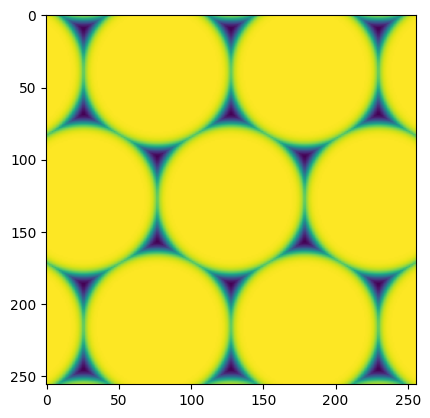

In [214]:


z, ext = generate_distance_field_lattice(
step_center=0.9, step_sharpness=30, lattice_a=4)
plt.imshow(z)

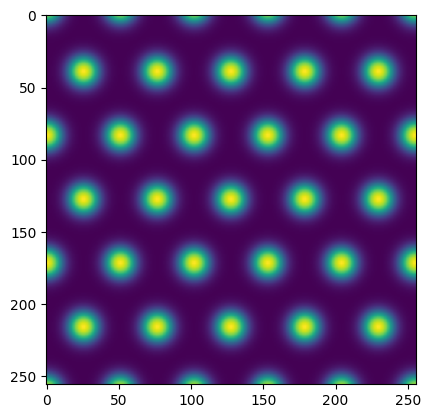

In [226]:
z, ext = generate_distance_field_lattice(
step_center=0.3, step_sharpness=10, lattice_a=2)
plt.imshow(z)

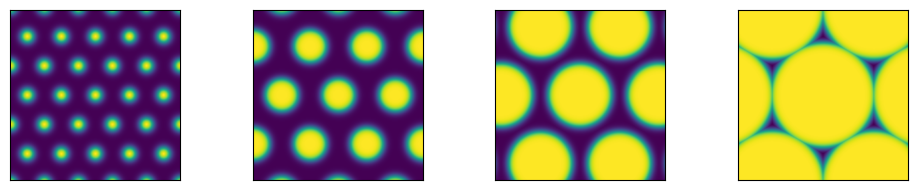

In [232]:
fig,axs = plt.subplots(1,4,figsize=(10,2))
step_centers = np.linspace(.3,.9,4)
step_sharpness = np.linspace(10,30,4)
lattice_as = np.linspace(2,6,4)
for ii in range(4):
    z, ext = generate_distance_field_lattice(
    step_center=step_centers[ii], step_sharpness=step_sharpness[ii], lattice_a=lattice_as[ii])
    axs[ii].imshow(z)
    plt.sca(axs[ii])
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()
plt.savefig('C06_2dschematic_generator_fig4.svg', format='svg', bbox_inches='tight')


# 1d plot

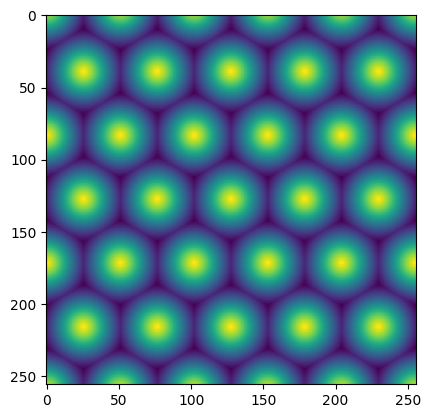

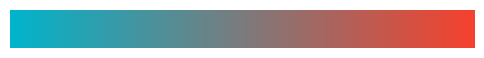

In [176]:
import matplotlib.pyplot as plt

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

first_color = colors[0]  # '#1f77b4' (tab:blue)
second_color = colors[1] # '#ff7f0e' (tab:orange)
first_color = '#E66100'
second_color ='#009E73'# colors[1] # '#ff7f0e' (tab:orange)
first_color = '#6B9AC4'
second_color ='#FF6F61'# colors[1] # '#ff7f0e' (tab:orange)
first_color = '#00B5CC'
second_color = '#F6412D'

from matplotlib.colors import LinearSegmentedColormap

cmap = LinearSegmentedColormap.from_list('first_to_second', [first_color, second_color])
import numpy as np

plt.figure(figsize=(6, 0.5))
plt.imshow([np.linspace(0, 1, 256)], aspect='auto', cmap=cmap)
plt.axis('off')
plt.show()


In [177]:
def arr_phis(dw_density,dw_pinning,dw_shift):
    """get array of phi and delta-phi about soliton lattice    
    Args: 
        dw_density (float,[0,1)): density of domain wall. if 1, 1 domain per length 1
        dw_pinning (float,+): pinning of domain wall. if 1, sigma is 1
        dw_shift (float,[0,3)): shift of domain wall. if 0, reference dw's position is 0
    Returns:
        x (arr,(900,)): position of domain wall.
        phi (arr,(900,)): phase of domain wall.
        delta_phi (arr,(900,)): phase difference of domain wall.
    """
    x = np.linspace(-1, 1, 901)
    z_min = int(np.ceil((-1 - dw_shift) / dw_density))
    z_max = int(np.floor((2 - dw_shift) / dw_density))
    dw_pos = dw_density * np.arange(z_min, z_max + 1) + dw_shift
    print(dw_pos)
    from scipy.stats import norm
    delta_phi = np.zeros_like(x)
    for pos in dw_pos:
        delta_phi += norm.pdf(x, loc=pos, scale=dw_pinning)    
    phi = np.cumsum(delta_phi) * (x[1] - x[0])# * (2 * np.pi / 3)
    phi -= phi[np.argmin(np.abs(x))]
    return x, phi, delta_phi,dw_pos

[0. 2.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0. 2.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]


<>:27: SyntaxWarning: invalid escape sequence '\p'
<>:31: SyntaxWarning: invalid escape sequence '\p'
<>:27: SyntaxWarning: invalid escape sequence '\p'
<>:31: SyntaxWarning: invalid escape sequence '\p'
C:\Users\user\AppData\Local\Temp\ipykernel_40812\2671576652.py:27: SyntaxWarning: invalid escape sequence '\p'
  plt.ylabel("$d\phi/dx$ [arb.]")
C:\Users\user\AppData\Local\Temp\ipykernel_40812\2671576652.py:31: SyntaxWarning: invalid escape sequence '\p'
  plt.ylabel("$\phi$ [arb.]")


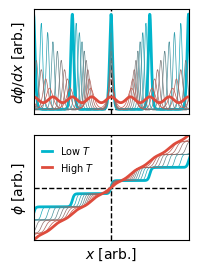

In [209]:

dw_density_start = 2
dw_density_end = 4
dw_smoothness_start = 20
dw_smoothness_end = 2.5

num_schematics = 10
dw_density = np.linspace(dw_density_start,dw_density_end,num_schematics)
dw_smoothness = np.linspace(dw_smoothness_start,dw_smoothness_end,num_schematics)

fig,ax = plt.subplots(2,1,figsize=(2,3))
for iax in range(2):
    plt.sca(ax[iax])
    plt.axhline(y=0, color='k', lw=1,ls='--')
    plt.axvline(x=0, color='k', lw=1,ls='--')
    plt.xlim(-1,1)
# plt.ylim(-2,2)
    plt.grid(True)
    for i in range(num_schematics):
        # x,phi,dlt,sth = arr_phis(dw_density[i],dw_smoothness[i],0)
        x,phi,dlt,sth = arr_phis(dw_density[i],dw_smoothness[i],0)
        phi = (phi - phi[::-1]) / 2
        lw = 2 if i == 0 or i == num_schematics - 1 else .5
        label = 'Low $T$' if i == 0 else 'High $T$' if i == num_schematics - 1 else None
        phi,dlt = generate_smooth_staircase_pulse(x_domain, density=dw_density[i], sharpness=dw_smoothness[i])
        if iax == 0:
            plt.plot(x_domain, dlt, c=cmap(i/num_schematics), lw=lw, label=label)
            plt.ylabel("$d\phi/dx$ [arb.]")
        else:
            plt.plot(x_domain, phi, c=cmap(i/num_schematics), lw=lw, label=label)
            plt.ylim([-4,4])
            plt.ylabel("$\phi$ [arb.]")
            plt.xlabel("$x$ [arb.]")
    

ax[1].legend(fontsize=7, frameon=False, loc='upper left', handlelength=1)
for a in ax:
    a.set_xticks([])
    a.set_yticks([])

plt.show()    

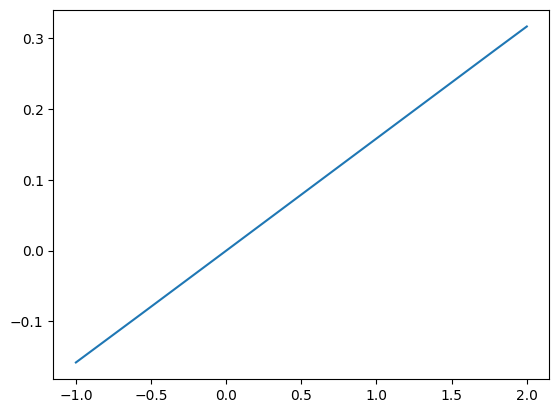

Sharpness 5.0: Peak Height = 2.50, Area per Step ≈ 0.33
Sharpness 50.0: Peak Height = 25.00, Area per Step ≈ 0.33


C:\Users\user\AppData\Local\Temp\ipykernel_40812\2101187011.py:62: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  total_area = np.trapz(P, x_domain) # Numerical integration


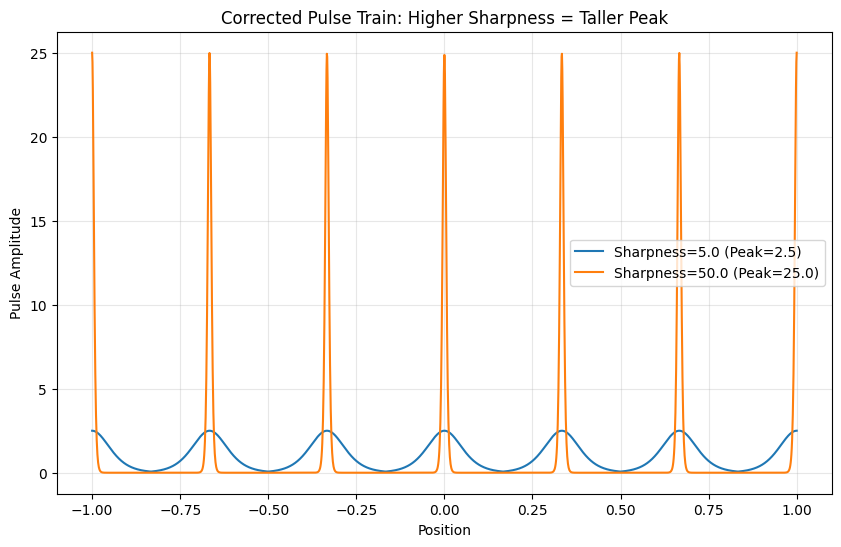

In [143]:
import numpy as np
import matplotlib.pyplot as plt

def generate_staircase_pulse_v2(
    x: np.ndarray, 
    density: float = 5.0, 
    sharpness: float = 10.0
) -> tuple[np.ndarray, np.ndarray]:
    """
    Generates Staircase and Pulse Train with CORRECT Amplitude scaling.
    
    Conservation Rule: Integral of Pulse (Area) = Step Height (1.0).
    Therefore, Peak Amplitude = Sharpness / 2.
    """
    
    # 1. Phase Calculation
    u = x * density
    
    # 2. Decomposition
    n = np.round(u)
    delta = u - n
    
    # 3. Staircase (Step Height = 1)
    # 0.5 * tanh goes from -0.5 to 0.5 (Total height 1)
    staircase = n + 0.5 * np.tanh(sharpness * delta)
    
    # 4. Pulse Train (Exact Derivative)
    # d/dx (0.5 * tanh(k*x)) = 0.5 * k * sech^2(k*x)
    # Note: We are looking at the shape relative to the phase 'delta'.
    # If we want strict dS/dx, we would also multiply by 'density', 
    # but usually, we want the pulse profile per lattice site.
    # Here, we scale by sharpness so Area = 1.
    
    cosh_arg = np.clip(sharpness * delta, -50, 50)
    
    # Amplitude Correction: Peak is now proportional to sharpness
    amplitude = sharpness / 2.0
    
    pulse = amplitude * (1.0 / (np.cosh(cosh_arg) ** 2))
    
    return staircase, pulse

# --- Verification: Area Conservation ---
if __name__ == "__main__":
    x_domain = np.linspace(-1, 1, 2000) # Higher resolution for integration
    rho = 3.0
    
    # Compare Low vs High Sharpness
    k_vals = [5.0, 50.0]
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    for k in k_vals:
        S, P = generate_staircase_pulse_v2(x_domain, density=rho, sharpness=k)
        
        # Plot Pulse
        ax.plot(x_domain, P, label=f'Sharpness={k} (Peak={k/2:.1f})')
        
        # Verify Area (Numerical Integration of one pulse)
        # One pulse exists in interval 1/rho (approx)
        # We check total integral over domain / number of steps
        total_area = np.trapz(P, x_domain) # Numerical integration
        num_steps = (x_domain.max() - x_domain.min()) * rho
        area_per_step = total_area / num_steps
        
        print(f"Sharpness {k}: Peak Height = {P.max():.2f}, Area per Step ≈ {area_per_step:.2f}")

    ax.set_title("Corrected Pulse Train: Higher Sharpness = Taller Peak")
    ax.set_ylabel("Pulse Amplitude")
    ax.set_xlabel("Position")
    ax.legend()
    ax.grid(True, alpha=0.3)
    plt.show()

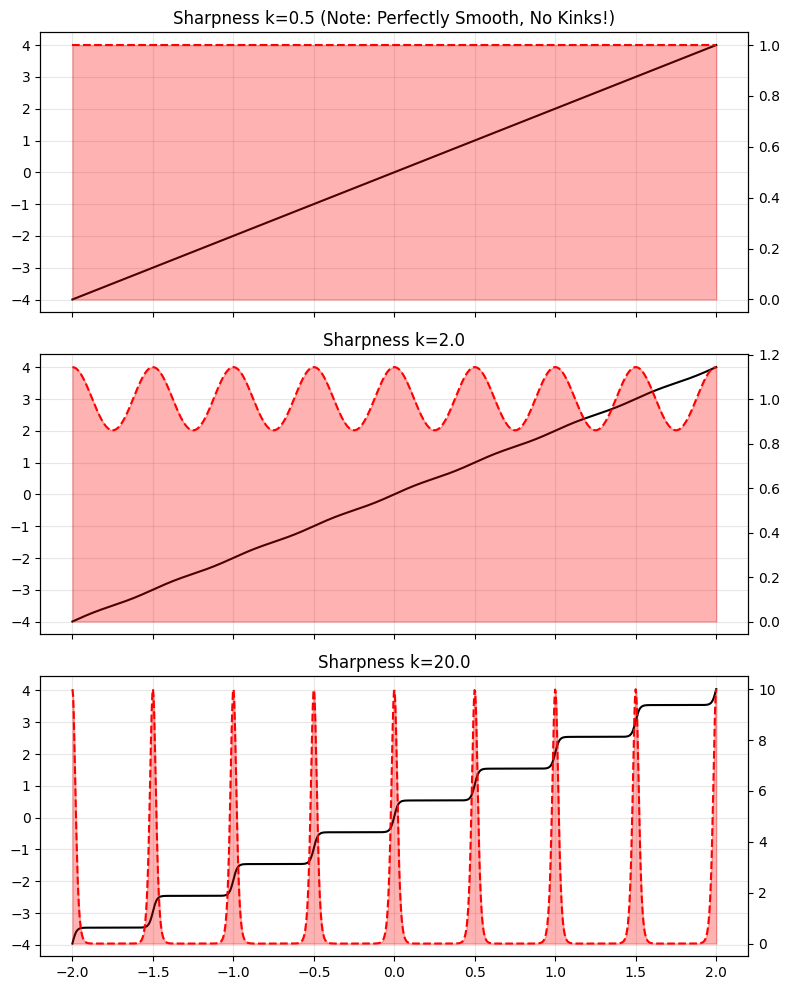

In [151]:
import numpy as np
import matplotlib.pyplot as plt

def generate_smooth_staircase_pulse(
    x: np.ndarray, 
    density: float = 5.0, 
    sharpness: float = 2.0
) -> tuple[np.ndarray, np.ndarray]:
    """
    Generates a perfectly smooth (C-infinity) Staircase and Pulse Train.
    
    Instead of finding the nearest integer (which causes kinks), 
    this calculates the superposition of all relevant smooth steps.
    
    S(u) = Sum_n [ 0.5 * (1 + tanh(k * (u - n))) ] - Offset
    """
    
    # 1. Phase Coordinate
    u = x * density
    
    # 2. Determine summation range (Integer indices)
    # We need to sum over integers 'n' that are close enough to the current 'u'.
    # Tanh decays to +/- 1.0 when |k*delta| > 5 roughly.
    # So we need margin > 5 / sharpness.
    margin = int(np.ceil(10.0 / (sharpness + 1e-5))) + 2
    
    n_min = int(np.floor(u.min())) - margin
    n_max = int(np.ceil(u.max())) + margin
    
    # Create a grid of integer indices [1, N_integers]
    n_indices = np.arange(n_min, n_max + 1)
    
    # 3. Vectorized Superposition (Broadcasting)
    # Shape of u: (M, 1)
    # Shape of n: (1, N)
    # Shape of delta: (M, N)
    u_col = u[:, np.newaxis]
    n_row = n_indices[np.newaxis, :]
    
    delta = u_col - n_row # Distance to every integer
    
    # --- Staircase Calculation ---
    # Each integer n contributes a step of height 1.
    # Step function: 0.5 * (1 + tanh(k * (u-n)))
    # Range of this function is 0 to 1.
    step_contributions = 0.5 * (1 + np.tanh(sharpness * delta))
    
    # Sum all contributions
    staircase_raw = np.sum(step_contributions, axis=1)
    
    # Centering Correction: 
    # We want S(0) to be 0 (or close to the center relative to x)
    # At u=0, the sum creates an offset based on how many negative integers we included.
    # We simply subtract the value at u=0 (or extrapolate) to zero the origin.
    # For robust centering relative to the domain origin:
    zero_idx = np.abs(u).argmin()
    staircase = staircase_raw - staircase_raw[zero_idx]
    
    # --- Pulse Train Calculation ---
    # Derivative of sum is sum of derivatives.
    # P(u) = Sum_n [ (k/2) * sech^2(k * (u-n)) ]
    
    # Clip for numerical stability of cosh
    cosh_arg = np.clip(sharpness * delta, -50, 50)
    
    # Amplitude = Sharpness / 2 (Area Conservation Rule)
    pulse_contributions = (sharpness / 2.0) * (1.0 / np.cosh(cosh_arg)**2)
    
    pulse = np.sum(pulse_contributions, axis=1)
    
    return staircase, pulse

# --- Verification Logic ---
if __name__ == "__main__":
    x_domain = np.linspace(-2, 2, 1000)
    rho = 2.0
    
    # Test very low sharpness to check for smoothness (No Kinks!)
    # k=0.5 means the steps are wider than the lattice spacing -> Strong overlap
    params = [0.5, 2.0, 20.0]
    
    fig, axes = plt.subplots(3, 1, figsize=(8, 10), sharex=True)
    
    for i, k in enumerate(params):
        S, P = generate_smooth_staircase_pulse(x_domain, density=rho, sharpness=k)
        
        ax = axes[i]
        ax.plot(x_domain, S, 'k-', label='Staircase')
        
        ax2 = ax.twinx()
        ax2.fill_between(x_domain, P, color='red', alpha=0.3)
        ax2.plot(x_domain, P, 'r--', label='Pulse')
        
        ax.set_title(f"Sharpness k={k}")
        ax.grid(True, alpha=0.3)
        
        # Highlight: Even at k=0.5, the curve is perfectly smooth sinusoidal-like
        if k < 1.0:
            ax.set_title(f"Sharpness k={k} (Note: Perfectly Smooth, No Kinks!)")

    plt.tight_layout()
    plt.show()